In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso
from sklearn.metrics import (classification_report, confusion_matrix,
                             mean_squared_error, r2_score, recall_score)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from xgboost import XGBClassifier, XGBRegressor, plot_importance

pd.options.display.max_columns = 50


In [7]:
df = pd.read_csv("train2.csv", low_memory=False)

In [8]:
df


,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,datasplit,campaign,source,medium,keyword,isTrueDirect,referralPath,adContent,visits,hits,pageviews,bounces,newVisits,transactionRevenue,continent,subContinent,country,...,latitude,longitude,networkLocation,browser,browserVersion,browserSize,operatingSystem,operatingSystemVersion,isMobile,mobileDeviceBranding,mobileDeviceModel,mobileInputSelector,mobileDeviceInfo,mobileDeviceMarketingName,flashVersion,language,screenColors,screenResolution,deviceCategory,criteriaParameters,page,slot,gclId,adNetworkType,isVideoAd
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,train,(not set),google,organic,(not provided),NaN,NaN,NaN,1,1,1.0,1.0,1.0,NaN,Asia,Western Asia,Turkey,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,train,(not set),google,organic,(not provided),NaN,NaN,NaN,1,1,1.0,1.0,1.0,NaN,Oceania,Australasia,Australia,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,train,(not set),google,organic,(not provided),NaN,NaN,NaN,1,1,1.0,1.0,1.0,NaN,Europe,Southern Europe,Spain,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,train,(not set),google,organic,google + online,NaN,NaN,NaN,1,1,1.0,1.0,1.0,NaN,Asia,Southeast Asia,Indonesia,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,train,(not set),google,organic,(not provided),True,NaN,NaN,1,1,1.0,1.0,NaN,NaN,Europe,Northern Europe,United Kingdom,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,Ch

In [9]:
df.dtypes


channelGrouping               object
date                           int64
fullVisitorId                 object
sessionId                     object
socialEngagementType          object
visitId                        int64
visitNumber                    int64
visitStartTime                 int64
datasplit                     object
campaign                      object
source                        object
medium                        object
keyword                       object
isTrueDirect                  object
referralPath                  object
adContent                     object
visits                         int64
hits                           int64
pageviews                    float64
bounces                      float64
newVisits                    float64
transactionRevenue           float64
continent                     object
subContinent                  object
country                       object
region                        object
metro                         object
c

In [10]:
# Déja contenu dans fullvisitorid + visitID
df.drop(["sessionId"], inplace=True, axis=1)


In [11]:
# NaN revenue = 0
df.transactionRevenue.fillna(0, inplace=True)


In [12]:
df


,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,datasplit,campaign,source,medium,keyword,isTrueDirect,referralPath,adContent,visits,hits,pageviews,bounces,newVisits,transactionRevenue,continent,subContinent,country,region,...,latitude,longitude,networkLocation,browser,browserVersion,browserSize,operatingSystem,operatingSystemVersion,isMobile,mobileDeviceBranding,mobileDeviceModel,mobileInputSelector,mobileDeviceInfo,mobileDeviceMarketingName,flashVersion,language,screenColors,screenResolution,deviceCategory,criteriaParameters,page,slot,gclId,adNetworkType,isVideoAd
0,Organic Search,20160902,1131660440785968503,Not Socially Engaged,1472830385,1,1472830385,train,(not set),google,organic,(not provided),NaN,NaN,NaN,1,1,1.0,1.0,1.0,0.0,Asia,Western Asia,Turkey,Izmir,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,Not Socially Engaged,1472880147,1,1472880147,train,(not set),google,organic,(not provided),NaN,NaN,NaN,1,1,1.0,1.0,1.0,0.0,Oceania,Australasia,Australia,not available in demo dataset,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,Not Socially Engaged,1472865386,1,1472865386,train,(not set),google,organic,(not provided),NaN,NaN,NaN,1,1,1.0,1.0,1.0,0.0,Europe,Southern Europe,Spain,Community of Madrid,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,Not Socially Engaged,1472881213,1,1472881213,train,(not set),google,organic,google + online,NaN,NaN,NaN,1,1,1.0,1.0,1.0,0.0,Asia,Southeast Asia,Indonesia,not available in demo dataset,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20160902,27294437909732085,Not Socially Engaged,1472822600,2,1472822600,train,(not set),google,organic,(not provided),True,NaN,NaN,1,1,1.0,1.0,NaN,0.0,Europe,Northern Europe,United Kingdom,not available in demo dataset,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome,not available in demo dataset,not 

In [13]:
len(df.columns)


54

In [14]:
# drop columns with only one unique value
for col in df.columns:
    if df[col].nunique(dropna=False) == 1:
        df.drop(col, axis=1, inplace=True)


In [15]:
len(df.columns)


34

In [16]:
# replace NaN in some columns with true/false
df.isTrueDirect = df.isTrueDirect.fillna(False).astype(bool)
df.bounces = df.bounces.fillna(False).astype(bool)
df.newVisits = df.newVisits.fillna(False).astype(bool)
df.isVideoAd = df.isVideoAd.fillna(True).astype(bool)


In [22]:
# columns with high proportion of unavailable data
for col in df.columns:
    counts = df[col].value_counts()
    total = df[col].isna().sum()
    if "not available in demo dataset" in counts:
        total += counts["not available in demo dataset"]
    if "(not set)" in counts:
        total += counts["(not set)"]
    if "(not provided)" in counts:
        total += counts["(not provided)"]
    if total / len(df[col]) > 0.9:
        print(col, total / len(df[col]))


campaign 0.9576098347485152
keyword 0.961975448540535
adContent 0.9878869433289106
page 0.9762519462669852
slot 0.9762519462669852
gclId 0.9761401777009538
adNetworkType 0.9762519462669852


In [13]:
# prendre log(1+x) du transactionRevenue
df["transactionRevenueLog"] = np.log1p(df["transactionRevenue"])


In [14]:
# créer une colonne avec l'argent dépensé jusqu'à maintenant par client
df_sorted = df.sort_values(["fullVisitorId", "visitNumber"])


In [15]:
visitor_id = 0
revenue = 0
hits = 0
cumulRevenueById = {}
cumulHitsById = {}
for idx, row in df_sorted.iterrows():
    if visitor_id != row.fullVisitorId:
        revenue = 0
        hits = 0
        first_visit_interval = 0
        first_visit_date = row.visitStartTime
        visitor_id = row.fullVisitorId
        previous_revenue = row.transactionRevenue
        previous_hits = row.hits
    else:
        revenue += previous_revenue
        hits += previous_hits
        previous_revenue = row.transactionRevenue
        previous_hits = row.hits
        first_visit_interval = (row.visitStartTime - first_visit_date) / (
            3600 * 24
        )  # convert in days
    cumulRevenueById[idx] = [np.log1p(revenue), hits, first_visit_interval]


In [16]:
df_sorted = pd.concat(
    [
        df_sorted,
        pd.DataFrame.from_dict(
            cumulRevenueById,
            orient="index",
            columns=["cum_sum_revenues_log", "total_hits", "time_since_first_visit"],
        ),
    ],
    axis=1,
)


In [17]:
df_sorted[df_sorted.fullVisitorId == "9670996124580137796"].sort_values("visitNumber")


,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,campaign,source,medium,keyword,isTrueDirect,referralPath,adContent,hits,pageviews,bounces,newVisits,transactionRevenue,continent,subContinent,country,region,metro,city,networkDomain,browser,operatingSystem,isMobile,deviceCategory,page,slot,gclId,adNetworkType,isVideoAd,transactionRevenueLog,cum_sum_revenues_log,total_hits,time_since_first_visit
878736,Referral,20161229,9670996124580137796,1483049843,1,1483049843,(not set),mall.googleplex.com,referral,NaN,False,/,NaN,14,11.0,False,True,0.0,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,rr.com,Chrome,Macintosh,False,desktop,NaN,NaN,NaN,NaN,True,0.000000,0.0,0,0.000000
903153,Referral,20170104,9670996124580137796,1483578435,2,1483578435,(not set),mall.googleplex.com,referral,NaN,True,/,NaN,19,12.0,False,False,0.0,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,rr.com,Chrome,Macintosh,False,desktop,NaN,NaN,NaN,NaN,True,0.000000,0.0,14,6.117963
902969,Organic Search,20170104,9670996124580137796,1483578797,3,1483578797,(not set),google,organic,(not provided),False,NaN,NaN,9,5.0,False,False,0.0,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,rr.com,Chrome,Macintosh,False,desktop,NaN,NaN,NaN,NaN,True,0.000000,0.0,33,6.122153
903211,Referral,20170104,9670996124580137796,1483578939,4,1483578939,(not set),mall.googleplex.com,referral,NaN,False,/,NaN,24,22.0,False,False,159980000.0,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,rr.com,Chrome,Macintosh,False,desktop,NaN,NaN,NaN,NaN,True,18.890559,0.0,42,6.123796


In [18]:
df = df_sorted
del df_sorted


In [19]:
def parse_url(url):
    splits = url.split(".")
    if len(splits) == 1:
        return url
    return splits[-2]


df.source = df.source.apply(parse_url)

counts = df.source.value_counts()
# only keep sources with more than 90 visits
df = df[df["source"].isin(counts[counts > 90].index)]


In [20]:
counts


google        430002
youtube       212697
(direct)      143028
googleplex     67511
Partners       16411
               ...  
barkpost           1
towson             1
tumblr             1
digg               1
whatsapp           1
Name: source, Length: 121, dtype: int64

In [21]:
# seulement 2.5% des lignes ont un gclId de renseigné.
# l'id ne nous donne pas vraiment d'information mais peut etre que la présence de l'id si
df["has_gcl"] = df.gclId.map(lambda x: 1 if x != "is_na" else 0).astype(bool)
df.drop("gclId", inplace=True, axis=1)


In [22]:
# idem pour "keyword" et "adContent"
df["has_keyword"] = df.keyword.map(
    lambda x: 1 if x not in (np.nan, "(not provided)") else 0
).astype(bool)
df.drop("keyword", inplace=True, axis=1)
df["has_adContent"] = df.adContent.map(lambda x: 1 if x != np.nan else 0).astype(bool)
df.drop("adContent", inplace=True, axis=1)


In [23]:
counts = df.browser.value_counts()
df = df[df["browser"].isin(counts[counts > 100].index)]


In [24]:
counts


Chrome                                         619500
Safari                                         182136
Firefox                                         36999
Internet Explorer                               19320
Edge                                            10163
Android Webview                                  7816
Safari (in-app)                                  6811
Opera Mini                                       6136
Opera                                            5638
UC Browser                                       2420
YaBrowser                                        2015
Coc Coc                                           727
Amazon Silk                                       561
Android Browser                                   534
Mozilla Compatible Agent                          373
MRCHROME                                          261
Maxthon                                           235
BlackBerry                                        184
Nintendo Browser            

In [25]:
df.drop("date", inplace=True, axis=1)  # redundant with visitStartTime


In [26]:
# create columns for visit start time
start_date = df.visitStartTime.apply(datetime.fromtimestamp)
df["visit_year"] = start_date.dt.year
df["visit_month"] = start_date.dt.month
df["visit_day"] = start_date.dt.day
df["visit_weekday"] = start_date.dt.weekday
df["visit_hour"] = start_date.dt.hour


In [27]:
def parse_domain(url):
    try:
        splits = url.split(".")
        if len(splits) == 1:
            return url
        return splits[0]
    except:
        return url


df.networkDomain = df.networkDomain.replace(["(not set)", "unknown.unknown"], np.nan)
df.networkDomain = df.networkDomain.apply(parse_domain)
df.fillna({"networkDomain": "other"}, inplace=True)


<AxesSubplot:>

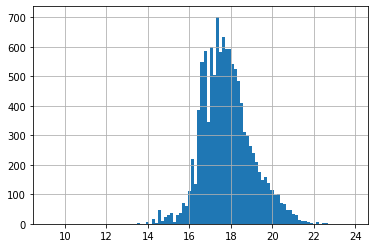

In [28]:
# normal distribution of transaction revenues log
df.transactionRevenueLog[df.transactionRevenueLog > 0].hist(bins=100)


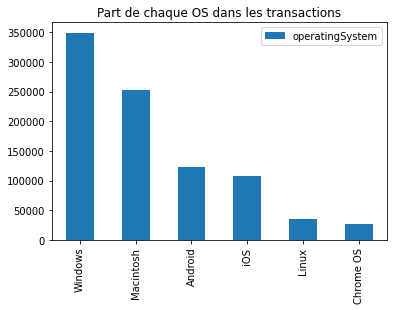

In [29]:
operating_systems = df.operatingSystem.value_counts().head(6)
operating_systems.plot(
    kind="bar", title="Part de chaque OS dans les transactions"
).legend(loc="best")


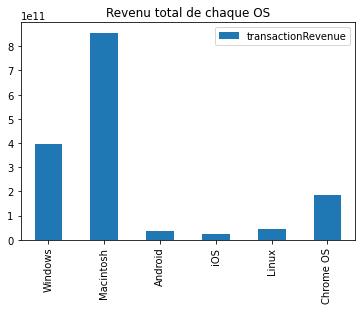

In [30]:
# group by operating system, sum the transactionRevenue, and plot by operating system
df.groupby("operatingSystem")["transactionRevenue"].sum().reindex(
    operating_systems.index
).plot(kind="bar", title="Revenu total de chaque OS").legend(loc="best")
# Les gens visitant les sites sur téléphones sont nombreux mais peu enclins à faire des achats


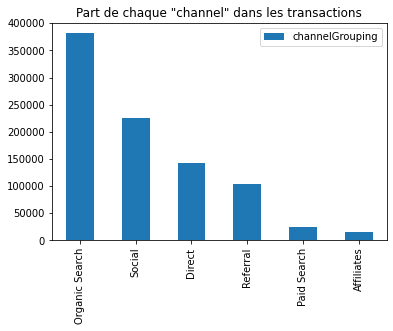

In [31]:
channel_grouping = df.channelGrouping.value_counts().head(6)
channel_grouping.plot(
    kind="bar", title='Part de chaque "channel" dans les transactions'
).legend(loc="best")


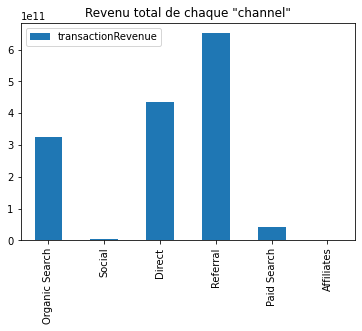

In [32]:
df.groupby("channelGrouping")["transactionRevenue"].sum().reindex(
    channel_grouping.index
).plot(kind="bar", title='Revenu total de chaque "channel"').legend(loc="best")
# Les recherches directes rapportent le plus, avec celles des moteurs de recherche (organic search)


In [33]:
df


,channelGrouping,fullVisitorId,visitId,visitNumber,visitStartTime,campaign,source,medium,isTrueDirect,referralPath,hits,pageviews,bounces,newVisits,transactionRevenue,continent,subContinent,country,region,metro,city,networkDomain,browser,operatingSystem,isMobile,deviceCategory,page,slot,adNetworkType,isVideoAd,transactionRevenueLog,cum_sum_revenues_log,total_hits,time_since_first_visit,has_gcl,has_keyword,has_adContent,visit_year,visit_month,visit_day,visit_weekday,visit_hour
230774,Organic Search,0000010278554503158,1477029466,1,1477029466,(not set),google,organic,False,NaN,11,8.0,False,True,0.0,Oceania,Australasia,New Zealand,not available in demo dataset,not available in demo dataset,not available in demo dataset,xtra,Chrome,Macintosh,False,desktop,NaN,NaN,NaN,True,0.0,0.0,0,0.000000,True,False,True,2016,10,21,4,7
89784,Organic Search,0000020424342248747,1480578901,1,1480578901,(not set),google,organic,False,NaN,17,13.0,False,True,0.0,Americas,South America,Peru,Lima Region,(not set),La Victoria,munitrujillo,Chrome,Windows,False,desktop,NaN,NaN,NaN,True,0.0,0.0,0,0.000000,True,False,True,2016,12,1,3,8
683463,Organic Search,0000027376579751715,1486866293,1,1486866293,(not set),google,organic,False,NaN,6,5.0,False,True,0.0,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,comcast,Chrome,Macintosh,False,desktop,NaN,NaN,NaN,True,0.0,0.0,0,0.000000,True,False,True,2017,2,12,6,3
648840,Social,0000039460501403861,1490629516,1,1490629516,(not set),youtube,referral,False,/yt/about/pt-BR/,2,2.0,False,True,0.0,Americas,South America,Brazil,not available in demo dataset,not available in demo dataset,not available in demo dataset,virtua,Chrome,Windows,False,desktop,NaN,NaN,NaN,True,0.0,0.0,0,0.000000,True,False,True,2017,3,27,0,17
683201,Paid Search,0000040862739425590,1486836571,1,1486836571,AW - Dynamic Search Ads Whole Site,google,cpc,False,NaN,2,2.0,False,True,0.0,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Oakland,comcastbusiness,Chrome,Macintosh,False,desktop,1.0,Top,Google Search,False,0.0,0.0,0,0.000000,True,True,True,2017,2,11,5,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182220,Organic Search,999997225970956660,1471672810,1,1471672810,(not set),google,organic,False,NaN,1,1.0,True,True,0.0,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,other,Safari,iOS,True,mobile,NaN,NaN,NaN,True,0.0,0.0,0,0.000000,True,False,True,2016,8,20,5,8
796213,Organic Search,999997550040396460,1491708533,1,1491708533,(not set),google,organic,False,NaN,1,1.0,True,True,0.0,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,d-pcomm,Chrome,Windows,False,desktop,NaN,NaN,NaN,True,0.0,0.0,0,0.000000,True,False,True,2017,4,9,6,5
812150,Organic Search,999997550040396460,1492640838,2,1492640838,(not set),google,organic,True,NaN,2,2.0,False,False,0.0,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,d-pcomm,Chrome,Windows,False,desktop,NaN,NaN,NaN,True,0.0,0.0,1,10.790567,True,False,True,2017,4,20,3,0
617541,Organic Search,9999978264901065827,1485325580,1,1485325580,(not set),google,organic,False,NaN,1,1.0,True,True,0.0,Americas,Northern America,United States,Washington,Seattle-Tacoma WA,Seattle,qwest,Chrome,Windows,False,desktop,NaN,NaN,NaN,True,0.0,0.0,0,0.000000,True,False,True,2017,1,25,2,7


In [34]:
df.select_dtypes(include="number").isna().sum()


visitId                        0
visitNumber                    0
visitStartTime                 0
hits                           0
pageviews                    100
transactionRevenue             0
page                      880509
transactionRevenueLog          0
cum_sum_revenues_log           0
total_hits                     0
time_since_first_visit         0
visit_year                     0
visit_month                    0
visit_day                      0
visit_weekday                  0
visit_hour                     0
dtype: int64

In [35]:
df[df.channelGrouping == "Paid Search"].page.value_counts() == df.page.value_counts()
# la colonne 'page' ne sert que pour les "paid search". On va donc remplacer NaN par 0 pour les autres channelGrouping
df.page.fillna(0, inplace=True)


In [36]:
# drop lines where pageviews is na
df = df[df.pageviews.notna()]


In [37]:
df.select_dtypes(include="number").isna().sum()


visitId                   0
visitNumber               0
visitStartTime            0
hits                      0
pageviews                 0
transactionRevenue        0
page                      0
transactionRevenueLog     0
cum_sum_revenues_log      0
total_hits                0
time_since_first_visit    0
visit_year                0
visit_month               0
visit_day                 0
visit_weekday             0
visit_hour                0
dtype: int64

In [38]:
# Replace the referralPath by the first part of the path, and take the 10 most common
# replace others by "other"
df["referralPathShort"] = df.referralPath.map(
    lambda x: x.split("/")[1] if type(x) != float else x
).replace(r"^\s*?$", np.nan, regex=True)
ref_counts = df.referralPathShort.value_counts()
df.referralPath = df.referralPathShort[
    df.referralPathShort.isin(ref_counts.head(10).index)
]
df.referralPath.fillna("other", inplace=True)
df.drop("referralPathShort", inplace=True, axis=1)


C:\Users\Maxime\AppData\Local\Temp/ipykernel_17492/3505664149.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["referralPathShort"] = df.referralPath.map(
C:\Users\Maxime\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\Maxime\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [39]:
# Take the 10 most common networkDomain
# replace others by "other"
df.networkDomain.replace(r"^\s*?$", np.nan, regex=True, inplace=True)
domain_counts = df.networkDomain.value_counts()
df.networkDomain = df.networkDomain[df.networkDomain.isin(domain_counts.head(10).index)]
df.networkDomain.fillna("other", inplace=True)


C:\Users\Maxime\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [40]:
# 2 categories, replace NaN by "is_na"
df.slot.fillna("is_na", inplace=True)
df.adNetworkType.fillna("is_na", inplace=True)


In [41]:
df.isna().sum()


channelGrouping           0
fullVisitorId             0
visitId                   0
visitNumber               0
visitStartTime            0
campaign                  0
source                    0
medium                    0
isTrueDirect              0
referralPath              0
hits                      0
pageviews                 0
bounces                   0
newVisits                 0
transactionRevenue        0
continent                 0
subContinent              0
country                   0
region                    0
metro                     0
city                      0
networkDomain             0
browser                   0
operatingSystem           0
isMobile                  0
deviceCategory            0
page                      0
slot                      0
adNetworkType             0
isVideoAd                 0
transactionRevenueLog     0
cum_sum_revenues_log      0
total_hits                0
time_since_first_visit    0
has_gcl                   0
has_keyword         

In [42]:
df.dtypes


channelGrouping            object
fullVisitorId              object
visitId                     int64
visitNumber                 int64
visitStartTime              int64
campaign                   object
source                     object
medium                     object
isTrueDirect                 bool
referralPath               object
hits                        int64
pageviews                 float64
bounces                      bool
newVisits                    bool
transactionRevenue        float64
continent                  object
subContinent               object
country                    object
region                     object
metro                      object
city                       object
networkDomain              object
browser                    object
operatingSystem            object
isMobile                     bool
deviceCategory             object
page                      float64
slot                       object
adNetworkType              object
isVideoAd     

In [43]:
# we drop ids, medium because similar to channelGrouping and country/region/city/metro
df.drop(
    [
        "fullVisitorId",
        "visitId",
        "medium",
        "country",
        "region",
        "metro",
        "city",
        "transactionRevenue",
    ],
    axis=1,
    inplace=True,
)


In [44]:
df.head(2)


,channelGrouping,visitNumber,visitStartTime,campaign,source,isTrueDirect,referralPath,hits,pageviews,bounces,newVisits,continent,subContinent,networkDomain,browser,operatingSystem,isMobile,deviceCategory,page,slot,adNetworkType,isVideoAd,transactionRevenueLog,cum_sum_revenues_log,total_hits,time_since_first_visit,has_gcl,has_keyword,has_adContent,visit_year,visit_month,visit_day,visit_weekday,visit_hour
230774,Organic Search,1,1477029466,(not set),google,False,other,11,8.0,False,True,Oceania,Australasia,other,Chrome,Macintosh,False,desktop,0.0,is_na,is_na,True,0.0,0.0,0,0.0,True,False,True,2016,10,21,4,7
89784,Organic Search,1,1480578901,(not set),google,False,other,17,13.0,False,True,Americas,South America,other,Chrome,Windows,False,desktop,0.0,is_na,is_na,True,0.0,0.0,0,0.0,True,False,True,2016,12,1,3,8


In [45]:
cat_cols = [
    "channelGrouping",
    "campaign",
    "source",
    "browser",
    "operatingSystem",
    "referralPath",
    "networkDomain",
    "continent",
    "subContinent",
    "deviceCategory",
    "slot",
    "adNetworkType",
]

dummies = pd.get_dummies(df[cat_cols])
df.drop(cat_cols, axis=1, inplace=True)
df = pd.concat([df, dummies], axis=1)


C:\Users\Maxime\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [46]:
df


,visitNumber,visitStartTime,isTrueDirect,hits,pageviews,bounces,newVisits,isMobile,page,isVideoAd,transactionRevenueLog,cum_sum_revenues_log,total_hits,time_since_first_visit,has_gcl,has_keyword,has_adContent,visit_year,visit_month,visit_day,visit_weekday,visit_hour,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,...,subContinent_Eastern Europe,subContinent_Melanesia,subContinent_Micronesian Region,subContinent_Middle Africa,subContinent_Northern Africa,subContinent_Northern America,subContinent_Northern Europe,subContinent_Polynesia,subContinent_South America,subContinent_Southeast Asia,subContinent_Southern Africa,subContinent_Southern Asia,subContinent_Southern Europe,subContinent_Western Africa,subContinent_Western Asia,subContinent_Western Europe,deviceCategory_desktop,deviceCategory_mobile,deviceCategory_tablet,slot_RHS,slot_Top,slot_is_na,adNetworkType_Google Search,adNetworkType_Search partners,adNetworkType_is_na
230774,1,1477029466,False,11,8.0,False,True,False,0.0,True,0.0,0.0,0,0.000000,True,False,True,2016,10,21,4,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
89784,1,1480578901,False,17,13.0,False,True,False,0.0,True,0.0,0.0,0,0.000000,True,False,True,2016,12,1,3,8,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
683463,1,1486866293,False,6,5.0,False,True,False,0.0,True,0.0,0.0,0,0.000000,True,False,True,2017,2,12,6,3,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
648840,1,1490629516,False,2,2.0,False,True,False,0.0,True,0.0,0.0,0,0.000000,True,False,True,2017,3,27,0,17,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
683201,1,1486836571,False,2,2.0,False,True,False,1.0,False,0.0,0.0,0,0.000000,True,True,True,2017,2,11,5,19,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182220,1,1471672810,False,1,1.0,True,True,True,0.0,True,0.0,0.0,0,0.000000,True,False,True,2016,8,20,5,8,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
796213,1,1491708533,False,1,1.0,True,True,False,0.0,True,0.0,0.0,0,0.000000,True,False,True,2017,4,9,6,5,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
812150,2,1492640838,True,2,2.0,False,False,False,0.0,True,0.0,0.0,1,10.790567,True,False,True,2017,4,20,3,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
617541,1,1485325580,False,1,1.0,True,True,False,0.0,True,0.0,0.0,0,0.000000,True,False,True,2017,1,25,2,7,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1


In [47]:
df.to_csv("train2_clean.csv")

In [193]:
df = pd.read_csv("./train2_clean.csv", index_col=0, low_memory=False)


In [269]:
def scale_data(train: pd.DataFrame, test: pd.DataFrame):
    # Scale the data
    scaled_cols = [
        "hits",
        "time_since_first_visit",
        "total_hits",
        "visitNumber",
        "visitStartTime",
        "visit_year",
        "visit_month",
        "visit_day",
        "visit_weekday",
        "visit_hour",
    ]
    # train sklearn StandardScaler on train set
    scaler = StandardScaler()
    scaler.fit(train[scaled_cols])
    # transform train and test sets
    train[scaled_cols] = scaler.transform(train[scaled_cols])
    test[scaled_cols] = scaler.transform(test[scaled_cols])
    return train, test


def get_X_y_train_test(train, test):
    X_train, y_train = (
        train.drop(["transactionRevenueLog"], axis=1),
        train.transactionRevenueLog,
    )
    X_test, y_test = (
        test.drop(["transactionRevenueLog"], axis=1),
        test.transactionRevenueLog,
    )
    return X_train, X_test, y_train, y_test


# split_time = df[df.visitStartTime > df.visitStartTime.quantile(.8)].sort_values('visitStartTime').head(1).visitStartTime
# train = df[df.visitStartTime < int(split_time)]
# test = df[df.visitStartTime >= int(split_time)]

train, test = train_test_split(df, test_size=0.2, random_state=1)
train, test = scale_data(train, test)
X_train, X_test, y_train, y_test = get_X_y_train_test(train, test)

# Régression directement sur le dataset


In [263]:
# From https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d
def cv_comparison(models, X, y, cv):
    # Initiate a DataFrame for the averages and a list for all measures
    cv_accuracies = pd.DataFrame()
    r2s = []
    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of
    # all CVs to the list
    for model in models:
        model_name = str(model).split("(")[0]
        print(model_name)
        r2 = np.round(cross_val_score(model, X, y, scoring="r2", cv=cv), 4)
        r2s.append(r2)
        r2_avg = round(r2.mean(), 4)
        cv_accuracies[model_name] = [r2_avg]
    cv_accuracies.index = ["R^2"]
    return cv_accuracies, r2s


In [265]:
# Create the models to be tested
lasso_reg = Lasso()
rf_reg = RandomForestRegressor(n_estimators=20, max_depth=5, n_jobs=-1)
xgb_reg = XGBRegressor()
dt_reg = DecisionTreeRegressor()

# Put the models in a list to be used for Cross-Validation
models = [rf_reg, lasso_reg, dt_reg, xgb_reg]

# Run the Cross-Validation comparison with the models used in this analysis
comp, r2s = cv_comparison(models, X_train, y_train, 5)
comp


RandomForestRegressor
Lasso
DecisionTreeRegressor
XGBRegressor


,RandomForestRegressor,Lasso,DecisionTreeRegressor,XGBRegressor
R^2,0.2913,0.154,-0.3588,0.3378


In [270]:
model = XGBRegressor(
    subsample=0.9,
    reg_lambda=1,
    reg_alpha=2,
    learning_rate=0.1,
    n_estimators=180,
    tree_method="hist",
)
model.fit(X_train, y_train)
model.score(X_test, y_test)
# 0.36 ?

0.35608423474436035

In [185]:
mean_squared_error(y_test, model.predict(X_test), squared=False)
# 1.6..

1.6184440761744767

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

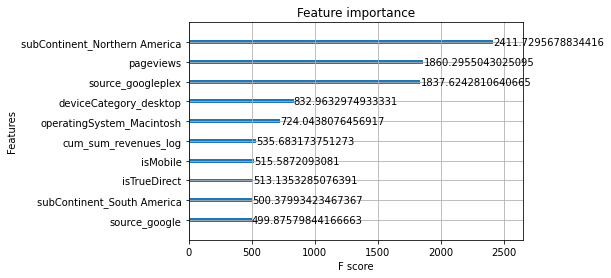

In [130]:
# xgboost plot importance
plot_importance(model, max_num_features=10, importance_type="gain")

In [278]:
predictions = pd.DataFrame([y_test, model.predict(X_test)], index=["y_test", "pred"]).T


In [281]:
predictions.fillna(0, inplace=True)
predictions[(predictions.y_test > 0)].head(20)


,y_test,pred
63931,14.910784,0.007626
174861,17.973299,0.000934
8224,17.279057,0.028180
19562,15.068274,0.022096
76297,16.769900,0.000951
43907,16.424845,0.000933
137660,17.617495,0.001251
95322,18.368861,0.001546
17263,16.705327,0.005503
157540,17.764829,0.009103


In [280]:
predictions = predictions[(predictions.y_test > 0) & (predictions.pred > 0)]

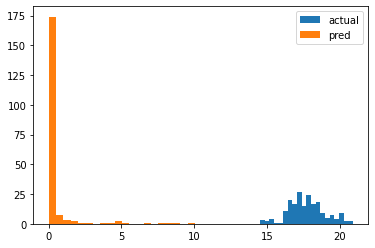

In [283]:
plt.figure()
plt.hist(predictions.y_test, bins=20, label="actual")
plt.hist(predictions.pred, bins=20, label="pred")
plt.legend()
plt.show()

In [269]:
model = XGBRegressor(
    subsample=0.9,
    reg_lambda=1,
    reg_alpha=2,
    learning_rate=0.1,
    n_estimators=180,
    tree_method="hist",
)

step = 3
min_features = 30

rfecv = RFECV(model, step=step, cv=2, min_features_to_select=min_features)

rfecv.fit(X_train, y_train)

C:\Users\Maxime\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


RFECV(cv=2,
      estimator=XGBRegressor(base_score=None, booster=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, gamma=None, gpu_id=None,
                             importance_type='gain',
                             interaction_constraints=None, learning_rate=0.1,
                             max_delta_step=None, max_depth=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, n_estimators=180,
                             n_jobs=None, num_parallel_tree=None,
                             random_state=None, reg_alpha=2, reg_lambda=1,
                             scale_pos_weight=None, subsample=0.9,
                             tree_method='hist', validate_parameters=None,
                             verbosity=None),
      min_features_to_select=30, step=3)

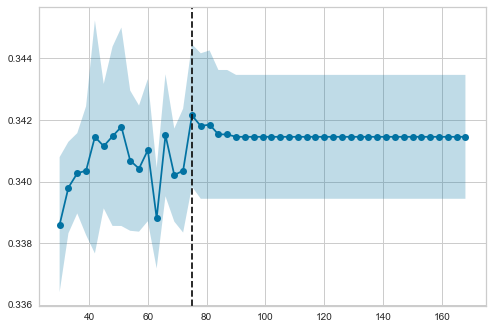

In [270]:
# Plot the RFECV results
plt.figure()

x = np.arange(min_features, X_train.shape[1] + step, step)
means = rfecv.cv_results_["mean_test_score"]
sigmas = rfecv.cv_results_["std_test_score"]

# Plot one standard deviation above and below the mean
plt.fill_between(x, means - sigmas, means + sigmas, alpha=0.25)

# Plot the curve
plt.plot(x, means, "o-")

# Plot the maximum number of features
plt.axvline(
    rfecv.n_features_,
    c="k",
    ls="--",
    label="n_features = {}\nscore = {:0.3f}".format(
        rfecv.n_features_, rfecv.cv_results_["mean_test_score"].max()
    ),
)

In [272]:
f"Optimal number of features: {rfecv.n_features_}"


'Optimal number of features: 75'

In [289]:
best_columns = rfecv.feature_names_in_[rfecv.support_]

df_best = df[best_columns]
# add transactionRevenueLog to df_best
df_best["transactionRevenueLog"] = df.transactionRevenueLog
# Fit the model with the best features
X = df_best.drop(["transactionRevenueLog"], axis=1)
y = df_best.transactionRevenueLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train, X_test = scale_data(X_train, X_test)

model = XGBRegressor(
    subsample=0.9,
    reg_lambda=1,
    reg_alpha=2,
    learning_rate=0.1,
    n_estimators=180,
    tree_method="hist",
)

model.fit(X_train, y_train)
model.score(X_test, y_test)

C:\Users\Maxime\AppData\Local\Temp/ipykernel_4544/4100872588.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_best["transactionRevenueLog"] = df.transactionRevenueLog


0.35065805370115344

# Classification des personnes n'ayant pas payé, puis régression pour ceux ayant payé


In [93]:
# creates a column with 1 if the transactionRevenueLog is > 0 and 0 otherwise
train["has_made_transaction"] = train.transactionRevenueLog.apply(
    lambda x: True if x > 0 else False
)
test["has_made_transaction"] = test.transactionRevenueLog.apply(
    lambda x: True if x > 0 else False
)


def get_X_y_train_test_classification(train, test):
    # Splits train and test into X and y for classif
    X_train, y_train = (
        train.drop(["transactionRevenueLog", "has_made_transaction"], axis=1),
        train.has_made_transaction,
    )
    X_test, y_test = (
        test.drop(["transactionRevenueLog", "has_made_transaction"], axis=1),
        test.has_made_transaction,
    )

    return X_train, X_test, y_train, y_test

X_train_classif, X_test_classif, y_train_classif, y_test_classif = get_X_y_train_test_classification(train, test)


In [13]:
classif = RandomForestClassifier()

classif.fit(X_train_classif, y_train_classif)
recall_score(y_test_classif, classif.predict(X_test_classif))


0.18825042881646656

In [143]:
classif = DecisionTreeClassifier(criterion="entropy")

classif.fit(X_train_classif, y_train_classif)
recall_score(y_test_classif, classif.predict(X_test_classif))

0.37821612349914235

In [139]:
classif = XGBClassifier(
    subsample=0.7,
    reg_lambda=0.5,
    eta=1.1,
    reg_alpha=0.8,
    tree_method="hist",
    use_label_encoder=False,
)

classif.fit(X_train_classif, y_train_classif)


[17:11:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=1.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=1.10000002, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0.8, reg_lambda=0.5, scale_pos_weight=1, subsample=0.7,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [142]:
recall_score(y_test_classif, classif.predict(X_test_classif))
# ~0.39 recall score with DecisionTreeClassifier(criterion="entropy")

0.35334476843910806

In [141]:
print(classification_report(y_test_classif, classif.predict(X_test_classif)))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99    178042
        True       0.46      0.35      0.40      2332

    accuracy                           0.99    180374
   macro avg       0.73      0.67      0.70    180374
weighted avg       0.98      0.99      0.99    180374



In [140]:
confusion_matrix(y_test_classif, classif.predict(X_test_classif))


array([[177093,    949],
       [  1508,    824]], dtype=int64)

In [144]:
df_reg = df.copy()
df_reg = df_reg[df_reg.transactionRevenueLog > 0]

In [145]:
# train the regression model on rows where transactionRevenueLog > 0
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    df_reg.drop(["transactionRevenueLog"], axis=1),
    df_reg.transactionRevenueLog,
    test_size=0.2,
    random_state=1,
)

In [146]:
regressor = XGBRegressor(
    subsample=0.9,
    reg_lambda=1,
    reg_alpha=2,
    learning_rate=0.1,
    n_estimators=180,
    tree_method="hist"
)

regressor.fit(X_train_reg, y_train_reg)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=180, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=2, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='hist', validate_parameters=1, verbosity=None)

In [147]:
regressor.score(X_test_reg, y_test_reg)

0.2601852528628641

In [148]:
results = pd.DataFrame(
    {
        "y_test": y_test_reg,
        "pred": regressor.predict(X_test_reg),
    }
)
r2_score(results.y_test, results.pred)


0.2601852528628641

In [149]:
mean_squared_error(results.y_test, results.pred, squared=False)

1.0312559999255413

In [150]:
df_reg

,visitNumber,visitStartTime,isTrueDirect,hits,pageviews,bounces,newVisits,isMobile,page,isVideoAd,transactionRevenueLog,cum_sum_revenues_log,total_hits,time_since_first_visit,has_gcl,has_keyword,has_adContent,visit_year,visit_month,visit_day,visit_weekday,visit_hour,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,...,subContinent_Eastern Europe,subContinent_Melanesia,subContinent_Micronesian Region,subContinent_Middle Africa,subContinent_Northern Africa,subContinent_Northern America,subContinent_Northern Europe,subContinent_Polynesia,subContinent_South America,subContinent_Southeast Asia,subContinent_Southern Africa,subContinent_Southern Asia,subContinent_Southern Europe,subContinent_Western Africa,subContinent_Western Asia,subContinent_Western Europe,deviceCategory_desktop,deviceCategory_mobile,deviceCategory_tablet,slot_RHS,slot_Top,slot_is_na,adNetworkType_Google Search,adNetworkType_Search partners,adNetworkType_is_na
131157,1,1493419318,True,14,13.0,False,True,False,0.0,True,17.329739,0.0,0,0.000000,True,False,True,2017,4,29,5,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
762279,5,1471964108,True,31,22.0,False,False,False,0.0,True,18.383498,0.0,5,19.533958,True,False,True,2016,8,23,1,16,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
126715,8,1476825602,True,94,66.0,False,False,False,0.0,True,17.875091,0.0,189,63.422072,True,False,True,2016,10,18,1,23,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1
326832,2,1495425682,True,26,20.0,False,False,False,0.0,True,15.420941,0.0,7,139.122141,True,False,True,2017,5,22,0,6,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
230829,2,1477013621,True,14,11.0,False,False,False,0.0,True,17.617495,0.0,14,4.149097,True,False,True,2016,10,21,4,3,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170012,1,1487376773,False,17,16.0,False,True,False,0.0,True,17.329739,0.0,0,0.000000,True,False,True,2017,2,18,5,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
342319,6,1470772818,True,42,30.0,False,False,False,0.0,True,18.715736,0.0,164,5.107350,True,False,True,2016,8,9,1,22,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
225288,2,1481250683,True,86,65.0,False,False,False,0.0,True,17.292434,0.0,0,0.000000,True,False,True,2016,12,9,4,3,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
537903,1,1470086006,True,37,33.0,False,True,False,0.0,True,18.392281,0.0,0,0.000000,True,False,True,2016,8,1,0,23,0,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1


In [151]:
df_reg.drop(["transactionRevenueLog"], axis=1)

,visitNumber,visitStartTime,isTrueDirect,hits,pageviews,bounces,newVisits,isMobile,page,isVideoAd,cum_sum_revenues_log,total_hits,time_since_first_visit,has_gcl,has_keyword,has_adContent,visit_year,visit_month,visit_day,visit_weekday,visit_hour,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,...,subContinent_Eastern Europe,subContinent_Melanesia,subContinent_Micronesian Region,subContinent_Middle Africa,subContinent_Northern Africa,subContinent_Northern America,subContinent_Northern Europe,subContinent_Polynesia,subContinent_South America,subContinent_Southeast Asia,subContinent_Southern Africa,subContinent_Southern Asia,subContinent_Southern Europe,subContinent_Western Africa,subContinent_Western Asia,subContinent_Western Europe,deviceCategory_desktop,deviceCategory_mobile,deviceCategory_tablet,slot_RHS,slot_Top,slot_is_na,adNetworkType_Google Search,adNetworkType_Search partners,adNetworkType_is_na
131157,1,1493419318,True,14,13.0,False,True,False,0.0,True,0.0,0,0.000000,True,False,True,2017,4,29,5,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
762279,5,1471964108,True,31,22.0,False,False,False,0.0,True,0.0,5,19.533958,True,False,True,2016,8,23,1,16,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
126715,8,1476825602,True,94,66.0,False,False,False,0.0,True,0.0,189,63.422072,True,False,True,2016,10,18,1,23,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1
326832,2,1495425682,True,26,20.0,False,False,False,0.0,True,0.0,7,139.122141,True,False,True,2017,5,22,0,6,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
230829,2,1477013621,True,14,11.0,False,False,False,0.0,True,0.0,14,4.149097,True,False,True,2016,10,21,4,3,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170012,1,1487376773,False,17,16.0,False,True,False,0.0,True,0.0,0,0.000000,True,False,True,2017,2,18,5,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
342319,6,1470772818,True,42,30.0,False,False,False,0.0,True,0.0,164,5.107350,True,False,True,2016,8,9,1,22,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
225288,2,1481250683,True,86,65.0,False,False,False,0.0,True,0.0,0,0.000000,True,False,True,2016,12,9,4,3,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
537903,1,1470086006,True,37,33.0,False,True,False,0.0,True,0.0,0,0.000000,True,False,True,2016,8,1,0,23,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1


In [152]:
df_reg["pred"] = regressor.predict(df_reg.drop(["transactionRevenueLog"], axis=1))

In [153]:
df_reg[["pred", "transactionRevenueLog"]].describe()

,pred,transactionRevenueLog
count,11505.000000,11505.000000
mean,17.822254,17.823561
std,0.717542,1.202827
min,13.281482,9.210440
25%,17.361956,17.031582
50%,17.725670,17.716473
75%,18.179701,18.496530
max,22.649412,23.864375


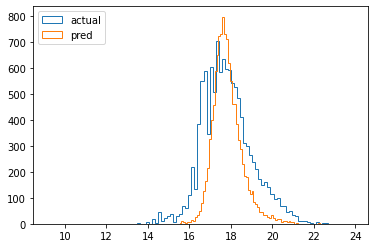

In [164]:
plt.figure()
plt.hist(df_reg.transactionRevenueLog, bins=100, label="actual")
plt.hist(df_reg.pred, bins=100, label="pred")
plt.legend()
plt.show()

In [155]:
# Combine results of the classification with the regression
# When classified as False, pred should be 0
# When classified as True, pred should be the value of the model_reg
classif_results = pd.DataFrame( { "id": test.index, "pred": classif.predict(X_test_classif) } )
reg_results = pd.DataFrame( { "id": test.index, "pred": regressor.predict(X_test_classif) } )

In [156]:
# Join the results of the classification and regression on column id when pred == 0 in classif_results
results = classif_results.merge(reg_results, on="id", how="left")
results["pred"] = results.apply(lambda row: row.pred_x if row.pred_x == 0 else row.pred_y, axis=1)
results.drop(["pred_x", "pred_y"], axis=1, inplace=True)
results.set_index("id", inplace=True)

In [157]:
#join results with test on index
results = results.merge(test["transactionRevenueLog"], left_index=True, right_index=True)

In [158]:
print("R² ", r2_score(results.transactionRevenueLog, results.pred))
print("RMSE", mean_squared_error(results.transactionRevenueLog, results.pred, squared=False))

R²  -0.9724492394500959
RMSE 2.7986576828411667


# Data Augmentation

In [284]:
train, test = train_test_split(df, test_size=0.2, random_state=1)
train, test = scale_data(train, test)
# Drop 30% of the lines with revenue = 0
revenue_0_sample = train[train["transactionRevenueLog"] == 0].sample(frac=.5)
train_reduced = train.loc[~train.index.isin(revenue_0_sample.index)]
# Upsample the lines with revenue > 0 on train set only
revenue_positive = train[train["transactionRevenueLog"] > 0]
# repeat 2 times then concatenate with the original dataframe
revenue_positive_upsample = revenue_positive.loc[revenue_positive.index.repeat(10)]
train_augmented = pd.concat([train_reduced, revenue_positive_upsample], axis=0)

X_train, X_test, y_train, y_test = get_X_y_train_test(train_augmented, test)

In [290]:
len(train_augmented[train_augmented.transactionRevenueLog > 0]) / len(train_augmented)

NameError: name 'test_augmented' is not defined

In [286]:
model = XGBRegressor(
    subsample=0.9,
    reg_lambda=1,
    reg_alpha=2,
    learning_rate=0.1,
    n_estimators=180,
    tree_method="hist",
)
model.fit(X_train, y_train)
scores = cross_val_score(model, X_test, y_test, scoring="r2", cv=5)
print("R²", scores.mean())
print("std", scores.std())

R² 0.3226646282802575
std 0.026058190350809276


In [287]:
mean_squared_error(y_test, model.predict(X_test), squared=False)

2.701453416514573

In [288]:
predictions = pd.DataFrame({"y_test": y_test, "pred": model.predict(X_test)})
predictions = predictions[predictions.y_test > 0]

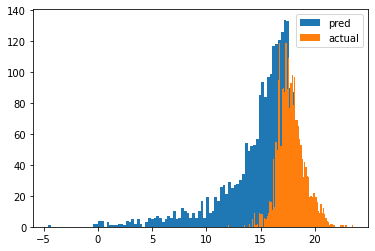

In [289]:
plt.figure()
plt.hist(predictions.pred, bins=100, label="pred")
plt.hist(predictions.y_test, bins=100, label="actual")
plt.legend()
plt.show()

In [268]:
import itertools
from tqdm import tqdm


drop_rates = np.arange(0.1, 0.61, 0.1)
repeat_rates = range(0, 4)
scores = {}

train, test = train_test_split(df, test_size=0.2, random_state=1)
train, test = scale_data(train, test)
# Upsample the lines with revenue > 0 on train set only
revenue_positive = train[train["transactionRevenueLog"] > 0]
for drop_rate, repeat_rate in tqdm(list(itertools.product(drop_rates, repeat_rates))):
    # Drop 30% of the lines with revenue = 0
    revenue_0_sample = train[train["transactionRevenueLog"] == 0].sample(frac=drop_rate)
    train_reduced = train.loc[~train.index.isin(revenue_0_sample.index)]
    # repeat n times then concatenate with the original dataframe
    revenue_positive_upsample = revenue_positive.loc[
        revenue_positive.index.repeat(repeat_rate)
    ]
    train_augmented = pd.concat([train_reduced, revenue_positive_upsample], axis=0)

    X_train, X_test, y_train, y_test = get_X_y_train_test(train_augmented, test)

    model = XGBRegressor(
        subsample=0.9,
        reg_lambda=1,
        reg_alpha=2,
        learning_rate=0.1,
        n_estimators=180,
        tree_method="hist",
    )

    model.fit(X_train, y_train)

    scores[(drop_rate, repeat_rate)] = mean_squared_error(
        y_test, model.predict(X_test), squared=False
    )


100%|██████████| 24/24 [06:06<00:00, 15.26s/it]


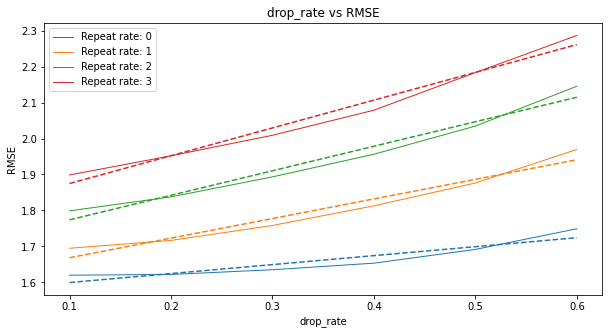

In [275]:
# plot scores
plt.figure(figsize=(10, 5))
for i, repeat_rate in enumerate(repeat_rates):
    x = drop_rates
    y = [scores[(drop_rate, repeat_rate)] for drop_rate in drop_rates]
    plt.plot(
        x,
        y,
        label=f"Repeat rate: {repeat_rate}",
        linewidth=1,
        color=f"C{i}",
    )
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), color=f"C{i}", linestyle="--")
plt.legend()
plt.xlabel("drop_rate")
plt.ylabel("RMSE")
plt.title("drop_rate vs RMSE")
plt.show()

In [18]:
import itertools
from tqdm import tqdm


test_sizes = np.linspace(0.1, 0.8, 25)
scores = {}

for test_size in tqdm(test_sizes):
    train, test = train_test_split(df, test_size=test_size)
    train, test = scale_data(train, test)
    X_train, X_test, y_train, y_test = get_X_y_train_test(train, test)
    model = XGBRegressor(
        subsample=0.9,
        reg_lambda=1,
        reg_alpha=2,
        learning_rate=0.1,
        n_estimators=180,
        tree_method="hist",
    )
    model.fit(X_train, y_train)
    scores[test_size] = model.score(X_test, y_test)


100%|██████████| 25/25 [07:44<00:00, 18.58s/it]


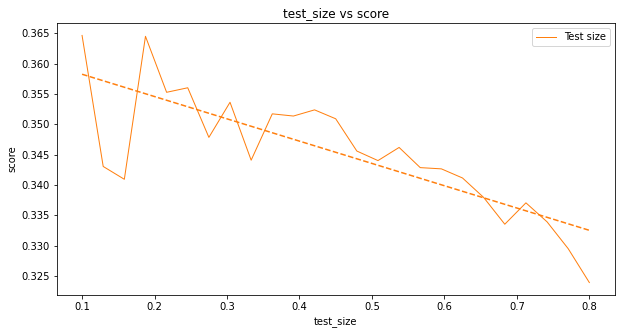

In [23]:
# plot scores
plt.figure(figsize=(10, 5))
x = test_sizes
y = [scores[test_size] for test_size in test_sizes]
plt.plot(
    x,
    y,
    label="Test size",
    linewidth=1,
    color="C1",
)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), color=f"C1", linestyle="--")
plt.legend()
plt.xlabel("test_size")
plt.ylabel("score")
plt.title("test_size vs score")
plt.show()